Copyright (c) <2022>, <Regina Nockerts>
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

In [1]:

import pandas as pd
import numpy as np
import os.path
from nlpUtils import aardvark as aa 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import random as rand

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

# Load the Data
First load the data from csv that was created at the end of the dataCleaningB notebook.


In [2]:
tweets_clean = pd.read_csv("archiveData/demoji_tweets_clean.csv", header=0, index_col=0)
print(tweets_clean.shape)
print(aa.term_check("❤️", tweets_clean))
print()
tweets_unlabeled = pd.read_csv("archiveData/demoji_tweets_unlabeled.csv", header=0, index_col=0)
print(tweets_unlabeled.shape)
print(aa.term_check("❤️", tweets_unlabeled))

(1211, 10)
('❤️', 0)

(200084, 5)
('❤️', 0)


# Look for imbalanced classes

In [3]:
# Find per-class percentages
total_ct = len(tweets_clean['y_sent'])
neg_ct, neu_ct, pos_ct = 0, 0, 0
for i in tweets_clean['y_sent']: 
    if i == 0:
        neg_ct += 1
    if i == 1:
        neu_ct += 1
    if i == 2:
        pos_ct += 1

neg_perct = round((neg_ct/total_ct)*100, 2)
neu_perct = round((neu_ct/total_ct)*100, 2)
pos_perct = round((pos_ct/total_ct)*100, 2)
print(neg_perct)
print(neu_perct)
print(pos_perct)

60.45
21.06
18.5


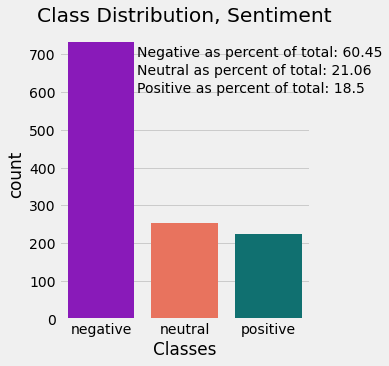

In [4]:
#plot class distribution
plt.figure(figsize=(4, 5))
plot_colors = ['darkviolet','tomato', 'teal']
sns.countplot(x=tweets_clean["y_sent"], palette=plot_colors).set_xticklabels(["negative", "neutral", "positive"])
plt.xlabel('Classes')
plt.title('Class Distribution, Sentiment')
plt.figtext(.35, .8, "Negative as percent of total: {}".format(neg_perct))
plt.figtext(.35, .75, "Neutral as percent of total: {}".format(neu_perct))
plt.figtext(.35, .7, "Positive as percent of total: {}".format(pos_perct));

10.07
46.33
40.38
3.22


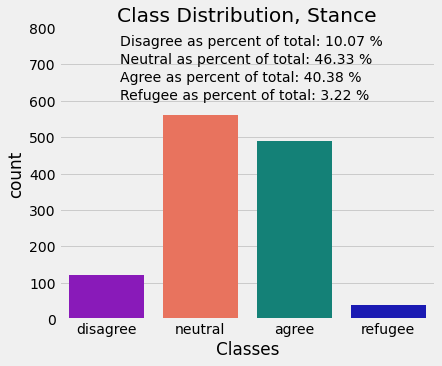

In [5]:
# Find per-class percentages
total_ct = len(tweets_clean['y_stance'])
disag_ct, neut_ct, agree_ct, ref_ct = 0, 0, 0, 0
for i in tweets_clean['y_stance']: 
    if i == 0:
        disag_ct += 1
    if i == 1:
        neut_ct += 1
    if i == 2:
        agree_ct += 1
    if i == 3:
        ref_ct += 1

disag_perct = round((disag_ct/total_ct)*100, 2)
neut_perct = round((neut_ct/total_ct)*100, 2)
agree_perct = round((agree_ct/total_ct)*100, 2)
ref_perct = round((ref_ct/total_ct)*100, 2)
print(disag_perct)
print(neut_perct)
print(agree_perct)
print(ref_perct)

#plot class distribution
plt.figure(figsize=(6, 5))
plot_colors = ['darkviolet', 'tomato', 'xkcd:teal', 'mediumblue']
sns.countplot(x=tweets_clean["y_stance"], palette=plot_colors).set_xticklabels(["disagree", "neutral", "agree", "refugee"])
plt.xlabel('Classes')
plt.title('Class Distribution, Stance')
plt.ylim(ymax = 800)
plt.figtext(.22, .83, "Disagree as percent of total: {} %".format(disag_perct))
plt.figtext(.22, .78, "Neutral as percent of total: {} %".format(neut_perct))
plt.figtext(.22, .73, "Agree as percent of total: {} %".format(agree_perct))
plt.figtext(.22, .68, "Refugee as percent of total: {} %".format(ref_perct));

### Dealing with Imbalanced Data
So we have imbalanced classes in both categories: far more negative than positive/neutral tweets, for fewer disaggree than agree/neutral tweets. 

We will need to deal with that before using machine learning algorithms, or the models will simply learn to predict the majority class. This will be a problem we need to address in the __training__ and __validation__ sets for ML. 

IN ADDITION: remember that our evaluation metric will be __F1 and AUC__. Create a confusion matrix.

### Tweet Length

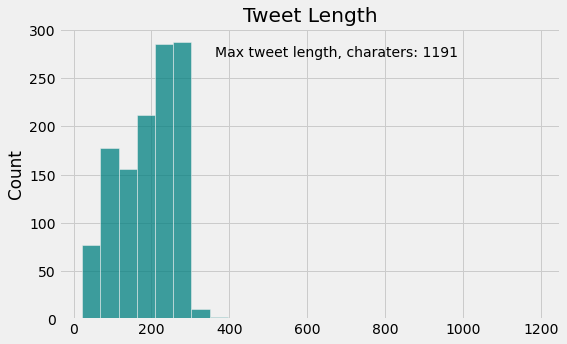

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot([len(s) for s in tweets_clean["ContentClean"]], bins=25, color="teal")
plt.figtext(.35, .8, "Max tweet length, charaters: {}".format(max([len(s) for s in tweets_clean["ContentClean"]])))
plt.title('Tweet Length')
# plt.style.use('ggplot') 
# plt.style.use('seaborn-white') 
plt.show()

So, there are some long ones in there... Which ones?

In [7]:
print(max([len(s) for s in tweets_clean["ContentClean"]]))
print(max([len(s) for s in tweets_unlabeled["ContentClean"]]))

1191
1572


In [8]:
long_tweets = []
for i, tweet in enumerate(tweets_clean["ContentClean"]):
    if len(tweet) > 500:
        long_tweets.append(i)
long_tweets

[111]

In [9]:
tweets_clean["ContentClean"].iloc[111]

'Trump Slams Afghan Refugee Plan, Defends Travel Ban:United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::United_States::Un

Exchanging the emoji for a text code has created some very long tweets, if you count by character. Fortunately, I don't think we need to count by character. Both VADER and BERT deal at the word-level.

length of longest tweet: 60


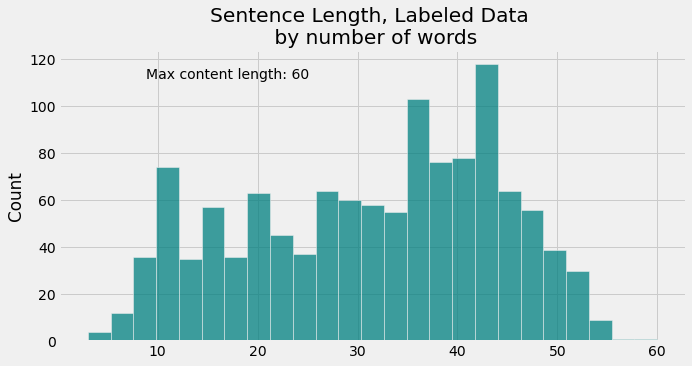

In [10]:
a = [len(i.split()) for i in tweets_clean["ContentClean"]]
max_a = (max(a))
ind_max_a = a.index(max_a)
print("length of longest tweet:", max_a)

plt.figure(figsize=(10, 5))
sns.histplot(a, bins=25, color="teal")
plt.title('Sentence Length, Labeled Data \n by number of words')
plt.figtext(.2, .8, "Max content length: {}".format(max(a)))
# plt.style.use('ggplot') 
# #plt.style.use('Solarize_Light2') 
# plt.style.use('seaborn-white') 
plt.show()

length of longest tweet: 63


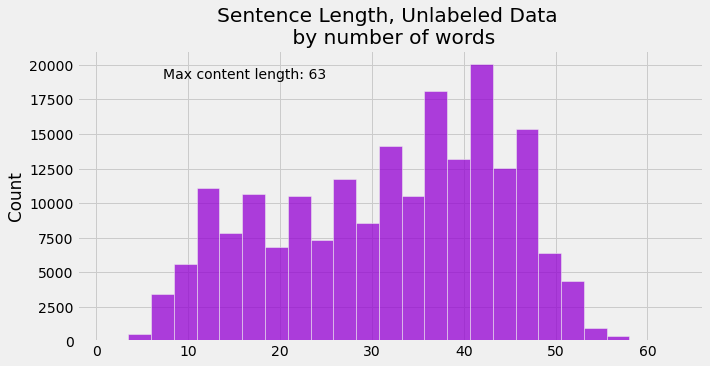

In [11]:
a = [len(i.split()) for i in tweets_unlabeled["ContentClean"]]
max_a = (max(a))
ind_max_a = a.index(max_a)
print("length of longest tweet:", max_a)

plt.figure(figsize=(10, 5))
sns.histplot(a, bins=25, color="darkviolet")
plt.title('Sentence Length, Unlabeled Data \n by number of words')
plt.figtext(.2, .8, "Max content length: {}".format(max(a)))
# plt.style.use('ggplot') 
# #plt.style.use('Solarize_Light2') 
# plt.style.use('seaborn-white') 
plt.show()

### PAUSE / UNPAUSE

In [12]:
# PAUSE
tweets_clean.to_csv(os.path.join('archiveData', "temp_tweets_clean.csv"))

# UNPAUSE
# tweets_clean = pd.read_csv(os.path.join('archiveData', "temp_tweets_clean.csv"), header=0, index_col=0)

# Split the Dataset: Train/Test Split
First we are going to split out a testing set. 

We have mild to moderately imbalanced data. We are going to KEEP the imbalance in the testing set. That way we will eventually be testing how the models work on data that looks like real-world data. That is important because, in the end, the intention is to apply the best model to the full dataset for real-world knowledge extraction. 

In [13]:
print(list(tweets_clean.columns))  

['id_stable', 'Date', 'Content', 'ContentClean', 'Labels', 'label_sent', 'y_sent', 'label_stance', 'y_stance', 'Flag']


In [14]:
# Create a df with the relevant X data
x_cols = ['id_stable', 'Date', 'ContentClean']
x_data = tweets_clean[x_cols]
print(x_data.shape)
x_data.head()

(1211, 3)


,id_stable,Date,ContentClean
0,170314,2021-08-15 17:53:06+00:00,Per a White House official: Biden and Harris m...
1,192623,2021-06-02 17:31:25+00:00,Afghan Refugee kid educated in Iran wins this ...
2,106982,2021-08-28 07:53:12+00:00,Not only did Trump stop processing asylum & re...
3,31609,2021-12-23 18:00:41+00:00,An Afghan refugee demands the US not forget he...
4,152666,2021-08-17 20:06:41+00:00,One moment you hate refugees and the next you ...


In [15]:
# Create a df with the relevant y data
y_cols = ['id_stable', 'label_sent', 'y_sent', 'label_stance', 'y_stance']
y_sent = tweets_clean[y_cols]
print(y_sent.shape)
y_sent.head()

(1211, 5)


,id_stable,label_sent,y_sent,label_stance,y_stance
0,170314,neutral,1,neutral,1
1,192623,happy,2,na,1
2,106982,disgust,0,neutral,1
3,31609,plea - disgust,0,refugee - agree,3
4,152666,hopeful,2,agree,2


In [16]:
# create the train and test, X and y sets,  
x_train, x_test, y_train_sent, y_test_sent = train_test_split(x_data, y_sent, test_size = 0.15, random_state = 1018, stratify = y_sent.y_sent.values)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train_sent:", y_train_sent.shape)
print("y_test_sent:", y_test_sent.shape)


x_train: (1029, 3)
x_test: (182, 3)
y_train_sent: (1029, 5)
y_test_sent: (182, 5)


Check that the test set distribution is similar to the full labeled data set.

60.44
20.88
18.68


Text(0.7, 0.7, 'Positive: 18.68 %')

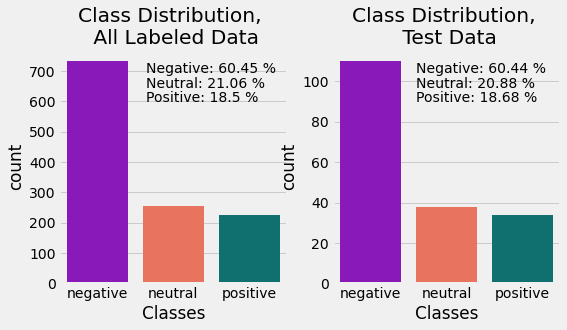

In [17]:
# Find the percentages
test_ct = len(y_test_sent['y_sent'])
neg_ct_test, neu_ct_test, pos_ct_test = 0, 0, 0
for i in y_test_sent['y_sent']: 
    if i == 0:
        neg_ct_test += 1
    if i == 1:
        neu_ct_test += 1
    if i == 2:
        pos_ct_test += 1

neg_perct_test = round((neg_ct_test/test_ct)*100, 2)
neu_perct_test = round((neu_ct_test/test_ct)*100, 2)
pos_perct_test = round((pos_ct_test/test_ct)*100, 2)
print(neg_perct_test)
print(neu_perct_test)
print(pos_perct_test)

# Check that the test set distribution is similar to the full labeled data set.
#plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1,2, figsize=(8, 4))
plot_colors = ['darkviolet','tomato', 'teal']

sns.countplot(x=tweets_clean["y_sent"], palette=plot_colors, ax=ax[0]).set_xticklabels(["negative", "neutral", "positive"])
ax[0].set_xlabel('Classes')
ax[0].set_title('Class Distribution, \n All Labeled Data');

sns.countplot(x=y_test_sent["y_sent"], palette=plot_colors, ax=ax[1]).set_xticklabels(["negative", "neutral", "positive"])
ax[1].set_xlabel('Classes')
ax[1].set_title('Class Distribution, \n Test Data');

plt.figtext(.23, .8, "Negative: {} %".format(neg_perct))
plt.figtext(.23, .75, "Neutral: {} %".format(neu_perct))
plt.figtext(.23, .7, "Positive: {} %".format(pos_perct))

plt.figtext(.7, .8, "Negative: {} %".format(neg_perct_test))
plt.figtext(.7, .75, "Neutral: {} %".format(neu_perct_test))
plt.figtext(.7, .7, "Positive: {} %".format(pos_perct_test))

The data distribution in the test set looks very good. Save it to dataBalancedSets.

In [18]:
x_test.to_csv("dataBalancedSets/x_test.csv")
y_test_sent.to_csv("dataBalancedSets/y_test_sent.csv")

Moving on.

# Balancing

We have mild to moderately imblanced data. This is not a problem for VADER but it MIGHT be a problem for BERT. 

In order to keep the preprocessing as similar as possible betweent the two models, if we are going to balance the data for one, we should balance the data for both.

So, we are going to try a few different methods of the following possibilities:
1. Just use unbalanced data for both
2. Undersampling
3. Undersampling & Oversampling

And if we have time...:

4. Undersampling & SMOTE
5. Undersampling & Back Translation

We will create one train/val dataset using each method and put them in the dataBalancedSets folder.

### CHECK THIS!!! _______________
stratify: in train_test_split: StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

This is an option to try if I get bad results with downsampling.

## Use the Unbalanced Data as a Set
option 1: Just use unbalanced data for both

622
60.45

217
21.09

190
18.46


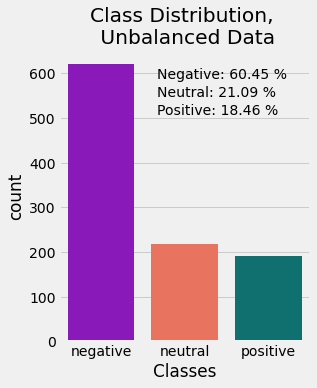

In [19]:
# We can just use the existing x and y datasets created when we sparated out the training set, above: x_train, y_train_sent
y_train_ct = len(y_train_sent['y_sent'])
neg_ct, neu_ct, pos_ct = 0, 0, 0
for i in y_train_sent['y_sent']: 
    if i == 0:
        neg_ct += 1
    if i == 1:
        neu_ct += 1
    if i == 2:
        pos_ct += 1

neg_perct_unbal = round((neg_ct/y_train_ct)*100, 2)
neu_perct_unbal = round((neu_ct/y_train_ct)*100, 2)
pos_perct_unbal = round((pos_ct/y_train_ct)*100, 2)

print(neg_ct)
print(neg_perct_unbal)
print()
print(neu_ct)
print(neu_perct_unbal)
print()
print(pos_ct)
print(pos_perct_unbal)

# Plot class distribution for the unbalanced set
plt.figure(figsize=(4, 5))
plot_colors = ['darkviolet','tomato', 'teal']
sns.countplot(x=y_train_sent["y_sent"], palette=plot_colors).set_xticklabels(["negative", "neutral", "positive"])
plt.xlabel('Classes')
plt.title('Class Distribution, \n Unbalanced Data')
plt.figtext(.42, .8, "Negative: {} %".format(neg_perct_unbal))
plt.figtext(.42, .75, "Neutral: {} %".format(neu_perct_unbal))
plt.figtext(.42, .7, "Positive: {} %".format(pos_perct_unbal));

In [20]:
# Take the training sets, and separate them out further for this. Split the data 80/20, stratified
unbal_x_train, unbal_x_val, unbal_y_train, unbal_y_val = train_test_split(x_train, y_train_sent, test_size = 0.20, random_state = 1018, stratify = y_train_sent.y_sent.values)
print("unbal_x_train:", unbal_x_train.shape)
print("unbal_x_val:", unbal_x_val.shape)
print("unbal_y_train:", unbal_y_train.shape)
print("unbal_y_val:", unbal_y_val.shape)

unbal_x_train: (823, 3)
unbal_x_val: (206, 3)
unbal_y_train: (823, 5)
unbal_y_val: (206, 5)


In [83]:
# Save them to CSV
unbal_x_train.to_csv("dataBalancedSets/unbal_x_train.csv")
unbal_x_val.to_csv("dataBalancedSets/unbal_x_val.csv")
unbal_y_train.to_csv("dataBalancedSets/unbal_y_train.csv")
unbal_y_val.to_csv("dataBalancedSets/unbal_y_val.csv")

## Create the dataset to balance from

In [21]:
temp_y = y_train_sent[["label_sent", "y_sent", "label_stance", "y_stance"]]
temp_data = pd.concat([x_train, temp_y], axis=1)  # x_train, x_test, y_train_sent, y_test_sent 
print(temp_data.shape)
temp_data.tail()

(1029, 7)


,id_stable,Date,ContentClean,label_sent,y_sent,label_stance,y_stance
1046,138237,2021-08-19 22:33:14+00:00,US & NATO countries need to open borders for t...,plea - disgust,0,agree,2
566,87392,2021-09-05 20:16:18+00:00,’13 Americans died so you could eat that meal’...,disgust,0,neutral,1
1039,144686,2021-08-18 19:38:17+00:00,Secretary Austin how are the Afghans coming to...,fear,0,disagree,0
77,153478,2021-08-17 18:02:17+00:00,Afghans fleeing the ravaged Afghanistan will h...,happy,2,agree,2
881,94972,2021-09-02 00:03:08+00:00,"Now, why the translators don’t fall under the ...",sad,0,agree,2


## Undersample
Option 2: Undersampling

Steps:
1. Undersample based on y_sent['y_sent'] == 0: Remove half
   1. Do this from a deep copy of the full labeled set
      1. can be modified without harming the full set
      2. Can be saved
   2. Save a list of negative label rows - will be used again
2. Train/Val split, 80/20%
3. Save with "under_" prefix

In [22]:
# Make a copy of temp_data that we can delete from using temp_data (which combines x_train and y_train_sent, above)
temp_under = temp_data.copy()
print(temp_under.shape)
print(list(temp_under.columns))

(1029, 7)
['id_stable', 'Date', 'ContentClean', 'label_sent', 'y_sent', 'label_stance', 'y_stance']


In [23]:
# Find the index of the negative rows
label_list = []
for i, label in enumerate(temp_under['y_sent']):
    if label == 0:
        label_list.append(i)
print(label_list[0:10])
print(len(label_list))

# shuffle the list
rand.seed(1018)
rand.shuffle(label_list)
print(label_list[0:10])
print(len(label_list))

# cut half the list out
cut_len = int(len(label_list)/2)
label_cut_list = label_list[:cut_len]
print(label_cut_list[0:10])
print(len(label_cut_list))


[1, 2, 5, 9, 11, 12, 13, 14, 15, 17]
622
[806, 875, 966, 449, 936, 633, 757, 616, 402, 543]
622
[806, 875, 966, 449, 936, 633, 757, 616, 402, 543]
311


In [24]:
# drop rows from temp_under using the list  df.drop(df.index[[1,3]])
print(temp_under.shape)
temp_under.drop(temp_under.index[label_cut_list], axis=0, inplace=True)
print(temp_under.shape)


(1029, 7)
(718, 7)


In [25]:
# see if it worked
under_ct = len(temp_under['y_sent'])
neg_ct, neu_ct, pos_ct = 0, 0, 0
for i in temp_under['y_sent']: 
    if i == 0:
        neg_ct += 1
    if i == 1:
        neu_ct += 1
    if i == 2:
        pos_ct += 1

neg_perct_under = round((neg_ct/under_ct)*100, 2)
neu_perct_under = round((neu_ct/under_ct)*100, 2)
pos_perct_under = round((pos_ct/under_ct)*100, 2)

print(neg_ct)
print(neg_perct_under)
print()
print(neu_ct)
print(neu_perct_under)
print()
print(pos_ct)
print(pos_perct_under)

311
43.31

217
30.22

190
26.46


Text(0.7, 0.7, 'Positive: 26.46 %')

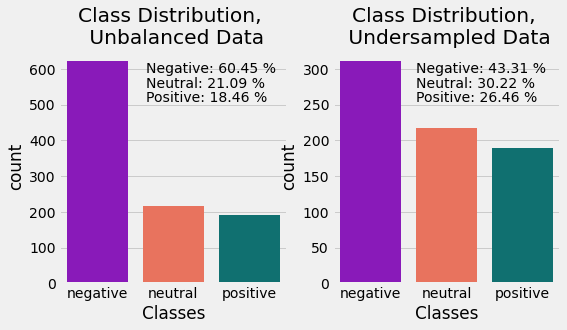

In [26]:
# Plot class distribuion.
fig, ax = plt.subplots(1,2, figsize=(8, 4))
plot_colors = ['darkviolet','tomato', 'teal']

sns.countplot(x=y_train_sent["y_sent"], palette=plot_colors, ax=ax[0]).set_xticklabels(["negative", "neutral", "positive"])
ax[0].set_xlabel('Classes')
ax[0].set_title('Class Distribution, \n Unbalanced Data');

sns.countplot(x=temp_under["y_sent"], palette=plot_colors, ax=ax[1]).set_xticklabels(["negative", "neutral", "positive"])
ax[1].set_xlabel('Classes')
ax[1].set_title('Class Distribution, \n Undersampled Data');

plt.figtext(.23, .8, "Negative: {} %".format(neg_perct_unbal))
plt.figtext(.23, .75, "Neutral: {} %".format(neu_perct_unbal))
plt.figtext(.23, .7, "Positive: {} %".format(pos_perct_unbal))

plt.figtext(.7, .8, "Negative: {} %".format(neg_perct_under))
plt.figtext(.7, .75, "Neutral: {} %".format(neu_perct_under))
plt.figtext(.7, .7, "Positive: {} %".format(pos_perct_under))

This is not quite balanced, but it is pretty good and I do not want to lose too much information.

In [27]:
# Divide out the x and y from temp_under
temp_x = temp_under[x_cols]
print(temp_x.shape)

temp_y = temp_under[y_cols]
print(temp_y.shape)
temp_y.head()

(718, 3)
(718, 5)


,id_stable,label_sent,y_sent,label_stance,y_stance
297,46187,neutral,1,na,1
340,3516,plea - sad,0,refugee,3
604,201328,neutral,1,agree,2
997,56935,plea - hopeful,2,agree,2
170,32376,disgust,0,refugee,3


In [28]:
# Split temp_under data 80/20
under_x_train, under_x_val, under_y_train, under_y_val = train_test_split(temp_x, temp_y, test_size = 0.20, random_state = 1018, stratify = temp_under.y_sent.values)
print("under_x_train:", under_x_train.shape)
print("under_x_val:", under_x_val.shape)
print("under_y_train:", under_y_train.shape)
print("under_y_val:", under_y_val.shape)

under_x_train: (574, 3)
under_x_val: (144, 3)
under_y_train: (574, 5)
under_y_val: (144, 5)


In [29]:
# Save the datasets to CSV
under_x_train.to_csv("dataBalancedSets/under_x_train.csv")
under_x_val.to_csv("dataBalancedSets/under_x_val.csv")
under_y_train.to_csv("dataBalancedSets/under_y_train.csv")
under_y_val.to_csv("dataBalancedSets/under_y_val.csv")

## Under/Oversample
Option 2: Undersampling and Oversampling combined

Steps:
1. Do this from a deep copy of the full labeled set
   1. can be modified without harming the full set
   2. Can be saved
2. Undersample based on y_sent['y_sent'] == 0: Remove 1/3
3. Train/Val split, 80/20%
   1. Need to split first, then duplicate in both 
4. Oversample based on y_sent['y_sent'] == 1: Double
5. Oversample based on y_sent['y_sent'] == 2: Double
6. Save with "underOver_" prefix

In [80]:
# Repeat the Undersample proceedure, but only removing 1/3 of the rows.

# Make a copy of temp_data that we can delete from using temp_data (which combines x_train and y_train_sent)
temp_underOver = temp_data.copy()
print("New dataset shape:", temp_underOver.shape)

# cut 1/3 the list out
cut_len = int(len(label_list)/3)
label_cut_list = label_list[:cut_len]
print("Length of label list:", len(label_list))
print("Cut length marker:", cut_len)
print("First ten labels of cut list", label_cut_list[0:10])
print("Length of cut list", len(label_cut_list))
print()

# drop rows from temp_under using the list  df.drop(df.index[[1,3]])
print("Original data shape:", temp_underOver.shape)
temp_underOver.drop(temp_underOver.index[label_cut_list], axis=0, inplace=True)
print("Undersampled data shape:", temp_underOver.shape)
print()

# see if it worked
underover_ct = len(temp_underOver['y_sent'])
negUnder_ct, neuUnder_ct, posUnder_ct = 0, 0, 0
for i in temp_underOver['y_sent']: 
    if i == 0:
        negUnder_ct += 1
    if i == 1:
        neuUnder_ct += 1
    if i == 2:
        posUnder_ct += 1

neg_perct_underOver = round((negUnder_ct/underover_ct)*100, 2)
neu_perct_underOver = round((neuUnder_ct/underover_ct)*100, 2)
pos_perct_underOver = round((posUnder_ct/underover_ct)*100, 2)

print("Class percentages:")
print(negUnder_ct)
print(neg_perct_underOver)
print()
print(neuUnder_ct)
print(neu_perct_underOver)
print()
print(posUnder_ct)
print(pos_perct_underOver)

New dataset shape: (1029, 7)
Length of label list: 622
Cut length marker: 207
First ten labels of cut list [806, 875, 966, 449, 936, 633, 757, 616, 402, 543]
Length of cut list 207

Original data shape: (1029, 7)
Undersampled data shape: (822, 7)

Class percentages:
415
50.49

217
26.4

190
23.11


In [81]:
# BEFORE doing the oversampling
# Divide out the x and y from temp_under 
temp_underOver_x = temp_underOver[x_cols]
print(temp_underOver_x.shape)

temp_underOver_y = temp_underOver[y_cols]
print(temp_underOver_y.shape)
temp_underOver_y.head()

(822, 3)
(822, 5)


,id_stable,label_sent,y_sent,label_stance,y_stance
297,46187,neutral,1,na,1
340,3516,plea - sad,0,refugee,3
604,201328,neutral,1,agree,2
997,56935,plea - hopeful,2,agree,2
170,32376,disgust,0,refugee,3


In [82]:
# Split the data 80/20
underOver_x_train, underOver_x_val, underOver_y_train, underOver_y_val = train_test_split(temp_underOver_x, temp_underOver_y, test_size = 0.20, random_state = 1018, stratify = temp_underOver_y.y_sent.values)
print("underOver_x_train:", underOver_x_train.shape)
print("underOver_x_val:", underOver_x_val.shape)
print("underOver_y_train:", underOver_y_train.shape)
print("underOver_y_val:", underOver_y_val.shape)

underOver_x_train: (657, 3)
underOver_x_val: (165, 3)
underOver_y_train: (657, 5)
underOver_y_val: (165, 5)


In [86]:
print(underOver_y_val.shape)
underOver_y_val.tail()

(165, 5)


,id_stable,label_sent,y_sent,label_stance,y_stance
792,72423,fear,0,refugee,3
432,198217,happy,2,neutral,1
535,53596,fear,0,agree,2
829,138512,disgust,0,agree,2
109,140780,happy,2,agree,2


In [91]:
# # label_list is a list of the negtive rows FROM temp_under(!). Working on underOver_... now.

# # Find the index of the positive and neutral rows, underOver_y_train
# print("Neu/Pos in underOver_y_train:")
# neu_train_list = []
# for i, label in zip(underOver_y_train.index, underOver_y_train['y_sent']):
#     if label == 1:
#         neu_train_list.append(i)
# print(neu_train_list[0:10])
# print(len(neu_train_list))

# pos_train_list = []
# for i, label in zip(underOver_y_train.index, underOver_y_train['y_sent']):
#     if label == 2:
#         pos_train_list.append(i)
# print(pos_train_list[0:10])
# print(len(pos_train_list))

# dup_train_index = sorted(neu_train_list + pos_train_list)
# print(dup_train_index[:10])
# print(dup_train_index[-10:])
# print(len(dup_train_index))
# print()

# # Find the index of the positive and neutral rows, underOver_y_val
# print("Neu/Pos in underOver_y_val:")
# neu_val_list = []
# for i, label in zip(underOver_y_val.index, underOver_y_val['y_sent']):
#     if label == 1:
#         neu_val_list.append(i)
# print(neu_val_list[0:10])
# print(len(neu_val_list))

# pos_val_list = []
# for i, label in zip(underOver_y_val.index, underOver_y_val['y_sent']):
#     if label == 2:
#         pos_val_list.append(i)
# print(pos_val_list[0:10])
# print(len(pos_val_list))

# dup_val_index = sorted(neu_val_list + pos_val_list)
# print(dup_val_index[:10])
# print(dup_val_index[-10:])
# print(len(dup_val_index))

Neu/Pos in underOver_y_train:
[976, 613, 748, 790, 636, 383, 760, 310, 101, 132]
173
[959, 398, 220, 430, 655, 1054, 769, 196, 1005, 212]
152
[0, 4, 6, 20, 24, 35, 39, 54, 59, 61]
[1187, 1192, 1195, 1197, 1198, 1199, 1202, 1204, 1205, 1206]
325

Neu/Pos in underOver_y_val:
[14, 575, 1036, 378, 533, 1140, 98, 556, 230, 140]
44
[1083, 205, 171, 1059, 1061, 1060, 974, 946, 1153, 1053]
38
[9, 14, 43, 57, 98, 104, 109, 140, 142, 161]
[1101, 1114, 1129, 1140, 1147, 1149, 1153, 1179, 1194, 1210]
82


In [93]:
# label_list is a list of the negtive rows FROM temp_under(!). Working on underOver_... now.

# Find the index of the positive and neutral rows, underOver_y_train
print("Neu/Pos in underOver_y_train:")
neu_train_list = []
for i, label in enumerate(underOver_y_train['y_sent']):
    if label == 1:
        neu_train_list.append(i)
print(neu_train_list[0:10])
print(len(neu_train_list))

pos_train_list = []
for i, label in enumerate(underOver_y_train['y_sent']):
    if label == 2:
        pos_train_list.append(i)
print(pos_train_list[0:10])
print(len(pos_train_list))

dup_train_index = sorted(neu_train_list + pos_train_list)
print(dup_train_index[:10])
print(dup_train_index[-10:])
print(len(dup_train_index))
print()

# Find the index of the positive and neutral rows, underOver_y_val
print("Neu/Pos in underOver_y_val:")
neu_val_list = []
for i, label in enumerate(underOver_y_val['y_sent']):
    if label == 1:
        neu_val_list.append(i)
print(neu_val_list[0:10])
print(len(neu_val_list))

pos_val_list = []
for i, label in enumerate(underOver_y_val['y_sent']):
    if label == 2:
        pos_val_list.append(i)
print(pos_val_list[0:10])
print(len(pos_val_list))

dup_val_index = sorted(neu_val_list + pos_val_list)
print(dup_val_index[:10])
print(dup_val_index[-10:])
print(len(dup_val_index))

Neu/Pos in underOver_y_train:
[1, 2, 15, 24, 25, 28, 31, 34, 36, 39]
173
[0, 6, 12, 14, 16, 17, 21, 40, 42, 44]
152
[0, 1, 2, 6, 12, 14, 15, 16, 17, 21]
[641, 642, 643, 644, 645, 646, 649, 651, 653, 654]
325

Neu/Pos in underOver_y_val:
[6, 7, 8, 11, 16, 20, 23, 35, 37, 42]
44
[3, 9, 12, 14, 19, 30, 34, 38, 39, 47]
38
[3, 6, 7, 8, 9, 11, 12, 14, 16, 19]
[149, 150, 151, 152, 154, 155, 158, 159, 161, 164]
82


In [94]:
## First on the TRAIN slit
# Duplicate the positive and negative rows, underOver_y_train
dup_y_train = underOver_y_train.iloc[dup_train_index]
print(dup_y_train.shape)

# Duplicate the positive and negative rows, underOver_x_train
dup_x_train = underOver_x_train.iloc[dup_train_index]
print(dup_x_train.shape)
# ________________

## Now on the VALIDATION split
# Duplicate the positive and negative rows, underOver_y_val
dup_y_val = underOver_y_val.iloc[dup_val_index]
print(dup_y_val.shape)

# Duplicate the positive and negative rows, underOver_x_val
dup_x_val = underOver_x_val.iloc[dup_val_index]
print(dup_x_val.shape)

dup_x_val.tail()

(325, 5)
(325, 3)
(82, 5)
(82, 3)


,id_stable,Date,ContentClean
909,54876,2021-10-14 03:52:48+00:00,The Canadian government has said it is accepti...
842,136309,2021-08-20 11:24:13+00:00,The EU's engagement to help those in Afghanist...
443,92791,2021-09-02 22:52:14+00:00,I can give away my room for an Afghan refugee ...
432,198217,2021-01-25 08:33:48+00:00,"I had a very good meeting with H.E. , Minister..."
109,140780,2021-08-19 13:13:30+00:00,AMAZING: Afghanistan Refugee-Turned-Soccer Sta...


In [95]:
dup_y_val.tail()

,id_stable,label_sent,y_sent,label_stance,y_stance
909,54876,hopeful,2,agree,2
842,136309,plea - neutral,1,agree,2
443,92791,happy,2,agree,2
432,198217,happy,2,neutral,1
109,140780,happy,2,agree,2


In [97]:
# Check that the indexes are the same 
print(dup_x_train['id_stable'].equals(dup_y_train['id_stable']))
print(dup_x_val['id_stable'].equals(dup_y_val['id_stable']))

True
True


In [98]:
# Add them back onto the dataset: underOver_y_train, underOver_x_train, underOver_y_val, underOver_x_val
underOver_y_train = pd.concat([underOver_y_train, dup_y_train], axis=0, ignore_index=True)
print(underOver_y_train.shape)

underOver_x_train = pd.concat([underOver_x_train, dup_x_train], axis=0, ignore_index=True)
print(underOver_x_train.shape)

underOver_y_val = pd.concat([underOver_y_val, dup_y_val], axis=0, ignore_index=True)
print(underOver_y_val.shape)

underOver_x_val = pd.concat([underOver_x_val, dup_x_val], axis=0, ignore_index=True)
print(underOver_x_val.shape)

underOver_x_val.tail()

(982, 5)
(982, 3)
(247, 5)
(247, 3)


,id_stable,Date,ContentClean
242,54876,2021-10-14 03:52:48+00:00,The Canadian government has said it is accepti...
243,136309,2021-08-20 11:24:13+00:00,The EU's engagement to help those in Afghanist...
244,92791,2021-09-02 22:52:14+00:00,I can give away my room for an Afghan refugee ...
245,198217,2021-01-25 08:33:48+00:00,"I had a very good meeting with H.E. , Minister..."
246,140780,2021-08-19 13:13:30+00:00,AMAZING: Afghanistan Refugee-Turned-Soccer Sta...


In [100]:
# see if it worked: underOver_y_train, underOver_y_val
print("Training data:")
underover_train_ct = len(underOver_y_train['y_sent'])
negUnder_ct, neuUnder_ct, posUnder_ct = 0, 0, 0
for i in underOver_y_train['y_sent']: 
    if i == 0:
        negUnder_ct += 1
    if i == 1:
        neuUnder_ct += 1
    if i == 2:
        posUnder_ct += 1

neg_perct_underOver_t = round((negUnder_ct/underover_train_ct)*100, 2)
neu_perct_underOver_t = round((neuUnder_ct/underover_train_ct)*100, 2)
pos_perct_underOver_t = round((posUnder_ct/underover_train_ct)*100, 2)

print("Class percentages:")
print(negUnder_ct, ":", neg_perct_underOver_t)
print(neuUnder_ct, ":", neu_perct_underOver_t)
print(posUnder_ct, ":", pos_perct_underOver_t)
print()

# see if it worked
print("Validation data:")
underover_val_ct = len(underOver_y_val['y_sent'])
negUnder_ct, neuUnder_ct, posUnder_ct = 0, 0, 0
for i in underOver_y_val['y_sent']: 
    if i == 0:
        negUnder_ct += 1
    if i == 1:
        neuUnder_ct += 1
    if i == 2:
        posUnder_ct += 1

neg_perct_underOver_v = round((negUnder_ct/underover_val_ct)*100, 2)
neu_perct_underOver_v = round((neuUnder_ct/underover_val_ct)*100, 2)
pos_perct_underOver_v = round((posUnder_ct/underover_val_ct)*100, 2)

print("Class percentages:")
print(negUnder_ct, ":", neg_perct_underOver_v)
print(neuUnder_ct, ":", neu_perct_underOver_v)
print(posUnder_ct, ":", pos_perct_underOver_v)

Training data:
Class percentages:
332 : 33.81
346 : 35.23
304 : 30.96

Validation data:
Class percentages:
83 : 33.6
88 : 35.63
76 : 30.77


Text(0.5, 1.0, 'Class Distribution, \n OVer-Under Validation Data')

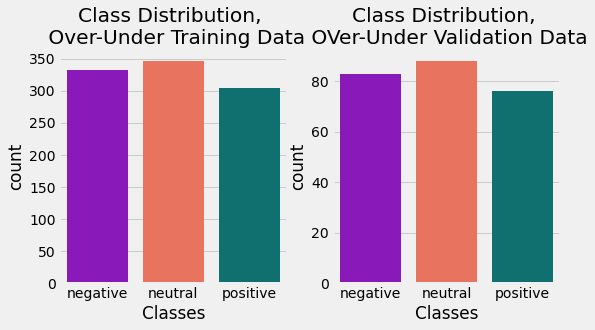

In [102]:
# Plot class distribuion: underOver_y_train V. underOver_y_val
fig, ax = plt.subplots(1,2, figsize=(8, 4))
plot_colors = ['darkviolet','tomato', 'teal']

sns.countplot(x=underOver_y_train["y_sent"], palette=plot_colors, ax=ax[0]).set_xticklabels(["negative", "neutral", "positive"])
ax[0].set_xlabel('Classes')
ax[0].set_title('Class Distribution, \n Over-Under Training Data');

sns.countplot(x=underOver_y_val["y_sent"], palette=plot_colors, ax=ax[1]).set_xticklabels(["negative", "neutral", "positive"])
ax[1].set_xlabel('Classes')
ax[1].set_title('Class Distribution, \n OVer-Under Validation Data')

# plt.figtext(.23, .8, "Negative: {} %".format(neg_perct_unbal))
# plt.figtext(.23, .75, "Neutral: {} %".format(neu_perct_unbal))
# plt.figtext(.23, .7, "Positive: {} %".format(pos_perct_unbal))
# plt.figtext(.63, .45, " Negative: {} % \n Neutral: {} % \n Positive: {} %".format(neg_perct_under, neu_perct_under, pos_perct_under), bbox=dict(facecolor='white', edgecolor='none', alpha=.65))

Text(0.63, 0.45, ' Negative: 33.81 % \n Neutral: 35.23 % \n Positive: 30.96 %')

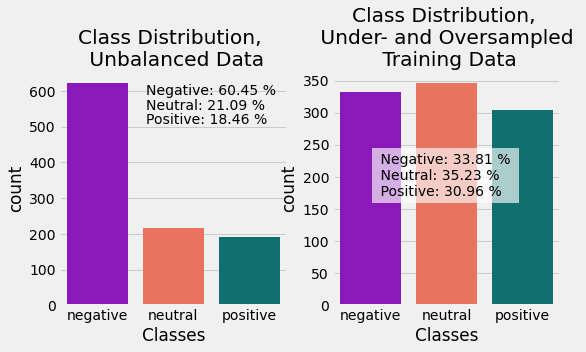

In [105]:
# Plot the new distributions: Unbalanced V. underOver_y_train
# Plot class distribuion.
fig, ax = plt.subplots(1,2, figsize=(8, 4))
plot_colors = ['darkviolet','tomato', 'teal']

sns.countplot(x=y_train_sent["y_sent"], palette=plot_colors, ax=ax[0]).set_xticklabels(["negative", "neutral", "positive"])
ax[0].set_xlabel('Classes')
ax[0].set_title('Class Distribution, \n Unbalanced Data');

sns.countplot(x=underOver_y_train["y_sent"], palette=plot_colors, ax=ax[1]).set_xticklabels(["negative", "neutral", "positive"])
ax[1].set_xlabel('Classes')
ax[1].set_title('Class Distribution, \n Under- and Oversampled \n Training Data')

plt.figtext(.23, .8, "Negative: {} %".format(neg_perct_unbal))
plt.figtext(.23, .75, "Neutral: {} %".format(neu_perct_unbal))
plt.figtext(.23, .7, "Positive: {} %".format(pos_perct_unbal))
plt.figtext(.63, .45, " Negative: {} % \n Neutral: {} % \n Positive: {} %".format(neg_perct_underOver_t, neu_perct_underOver_t, pos_perct_underOver_t), bbox=dict(facecolor='white', edgecolor='none', alpha=.65))

## SMOTe with Undersampling
Option 3: See if you can get SMOTe working

I don't think this is a great option, as the results that come back from SMOTe to plain text are likely to be jibberish. 
- What impact does this have on context?
- What impact does this have on negation?
- What impact does this have on complex language (ex: sarcasm)?
I am particularly concerned that VADER, which is very routineized, will not deal with this well.

Steps:
1. Undersample based on y_sent['y_sent'] == 0: Remove 1/3
   1. Do this from a deep copy of the full labeled set
      1. can be modified without harming the full set
      2. Can be saved
   1. Save a list of rows deleted (index or stable_id)
2. SMOTe positive class:
   1. Using the list of positive rows, save the positive instances from x_data to a new dataframe
   2. Encode "ContentClean" using the BERT tokenizer
      1. Confirm that these can go back and forth from text interchangably
   3. Run SMOTe, save new instances to a NEW df
   4. Decode using the BERT tokenizer
   5. Concat the relevant dfs
3. SMOTe neutral class:
   1. Using the list of neutral rows, save the neutral instances from x_data to a new dataframe
   2. Encode "ContentClean" using the BERT tokenizer
   3. Run SMOTe, save new instances to a NEW df
   4. Decode using the BERT tokenizer
   5. Concat the relevant dfs
4. Train/Val split, 80/20%
5. Save with "smote_" prefix

In [ ]:
# Divide out the x and y from temp_under
temp_x = temp_under[x_cols]
print(temp_x.shape)

temp_y = temp_under[y_cols]
print(temp_y.shape)
temp_y.head()

In [ ]:
# Split the data 80/20
# unbal_x_train, unbal_x_val, unbal_y_train, unbal_y_val = train_test_split(temp_x, temp_y, test_size = 0.20, random_state = 1018, stratify = y_train_sent.y_sent.values)
print("unbal_x_train:", unbal_x_train.shape)
print("unbal_x_val:", unbal_x_val.shape)
print("unbal_y_train:", unbal_y_train.shape)
print("unbal_y_val:", unbal_y_val.shape)

## Back Translation with Undersampling
Option 4: Try back translation

This is a more controversial approach. Changing the meaning of a sentance a bit but not too much is difficult. May need to validate this.

Steps:
1. Undersample based on y_sent['y_sent'] == 0: Remove 1/3
   1. Do this from a deep copy of the full labeled set
      1. can be modified without harming the full set
      2. Can be saved
   1. Save a list of rows deleted (index or stable_id)
2. back translate the positive class:
   1. Using the list of positive rows, save the positive instances from x_data to a new dataframe
   2. Use the labeler function to: 
      1. Get each instance from "ContentClean"
      2. Put it into google translate to German and back
      3. Insert this into the labeler to save to a new column, "ContentTrans"
   3. Delete the "ContentClean" column and remane "ContentTrans" to "ContentClean"
   4. Take a random subset of the rows, compare the two sentances for:
      1. They are actually different
      2. They have the same basic meaning
3. Back translate the neutral class:
   1. Using the list of neutral rows, save the neutral instances from x_data to a new dataframe
   2. Use the labeler function to: 
      1. Get each instance from "ContentClean"
      2. Put it into google translate to German and back
      3. Insert this into the labeler to save to a new column, "ContentTrans"
   3. Delete the "ContentClean" column and remane "ContentTrans" to "ContentClean"
   4. Take a random subset of the rows, compare the two sentances for:
      1. They are actually different
      2. They have the same basic meaning
4. Concat the relevant dfs
5. Train/Val split, 80/20%
6. Save with "backTrans_" prefix

In [ ]:
# Divide out the x and y from temp_under
temp_x = temp_under[x_cols]
print(temp_x.shape)

temp_y = temp_under[y_cols]
print(temp_y.shape)
temp_y.head()

In [ ]:
# Split the data 80/20
# unbal_x_train, unbal_x_val, unbal_y_train, unbal_y_val = train_test_split(temp_x, temp_y, test_size = 0.20, random_state = 1018, stratify = y_train_sent.y_sent.values)
print("unbal_x_train:", unbal_x_train.shape)
print("unbal_x_val:", unbal_x_val.shape)
print("unbal_y_train:", unbal_y_train.shape)
print("unbal_y_val:", unbal_y_val.shape)

# Save Clean, Split Files
For use with dictionary models: VADER, TextBlob

In [21]:
x_train.to_csv(os.path.join('data', "x_train.csv"))
x_val.to_csv(os.path.join('data', "x_val.csv"))
y_train_sent.to_csv(os.path.join('data', "y_train_sent.csv"))
y_val_sent.to_csv(os.path.join('data', "y_val_sent.csv"))

In [24]:
tweets_clean.to_csv(os.path.join('data', "all_labeled_tweets.csv"))
data_unlabeled.to_csv(os.path.join('data', "all_unlabeled_tweets.csv"))